# Northwind Analysis and Insights

In this notebook, I'll analyze the Northwind data and look for things that might be useful for a business to know so that they can increase their revenue and/or decrease their expenditures.

First, I'll import the libraries I'll be using:

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

And then I'll connect to the SQL database so that I can get the data I need.

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Hypothesis Test 1: Discounts and Quantity Sold

The first question I'm interested in is: Do discounts affect the number of sales of an item?  And, if they do, what level of discount affects it the most?

To investigate this, I'll pull data from the database about the orders including the products that were sold, what amounts were sold, and whether they were discounted or not.

In [3]:
c.execute("""SELECT d.*, o.CustomerId, o.OrderDate, p.ProductName, p.CategoryId, p.QuantityPerUnit, c.CategoryName
             FROM [Order] o
             JOIN OrderDetail d
             on o.Id=d.OrderId
             JOIN Product p
             on p.Id=d.ProductId
             JOIN Category c
             on c.Id=p.CategoryId
             """)
df1=pd.DataFrame(c.fetchall())
df1.columns = [x[0] for x in c.description]
df1.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,OrderDate,ProductName,CategoryId,QuantityPerUnit,CategoryName
0,10248/11,10248,11,14.0,12,0.0,VINET,2012-07-04,Queso Cabrales,4,1 kg pkg.,Dairy Products
1,10248/42,10248,42,9.8,10,0.0,VINET,2012-07-04,Singaporean Hokkien Fried Mee,5,32 - 1 kg pkgs.,Grains/Cereals
2,10248/72,10248,72,34.8,5,0.0,VINET,2012-07-04,Mozzarella di Giovanni,4,24 - 200 g pkgs.,Dairy Products
3,10249/14,10249,14,18.6,9,0.0,TOMSP,2012-07-05,Tofu,7,40 - 100 g pkgs.,Produce
4,10249/51,10249,51,42.4,40,0.0,TOMSP,2012-07-05,Manjimup Dried Apples,7,50 - 300 g pkgs.,Produce


In [4]:
df1.drop('Id',axis=1,inplace=True)

In [5]:
df1.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,OrderDate,ProductName,CategoryId,QuantityPerUnit,CategoryName
0,10248,11,14.0,12,0.0,VINET,2012-07-04,Queso Cabrales,4,1 kg pkg.,Dairy Products
1,10248,42,9.8,10,0.0,VINET,2012-07-04,Singaporean Hokkien Fried Mee,5,32 - 1 kg pkgs.,Grains/Cereals
2,10248,72,34.8,5,0.0,VINET,2012-07-04,Mozzarella di Giovanni,4,24 - 200 g pkgs.,Dairy Products
3,10249,14,18.6,9,0.0,TOMSP,2012-07-05,Tofu,7,40 - 100 g pkgs.,Produce
4,10249,51,42.4,40,0.0,TOMSP,2012-07-05,Manjimup Dried Apples,7,50 - 300 g pkgs.,Produce


Now, I want to see what different discounts were offered.

In [6]:
df1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

For fun, lets see how the quantities (per item per order) that were sold for each discount level.  I'll probably come back to this later - this is just to get a quick idea of what each discount level looks like to see if anything stands out.

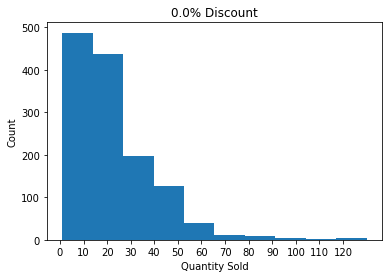

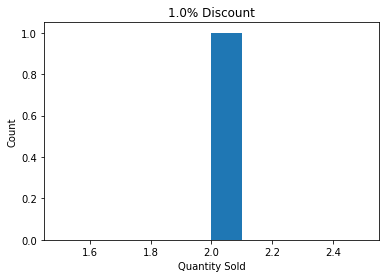

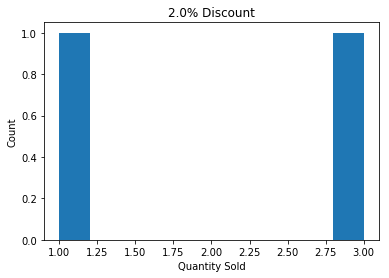

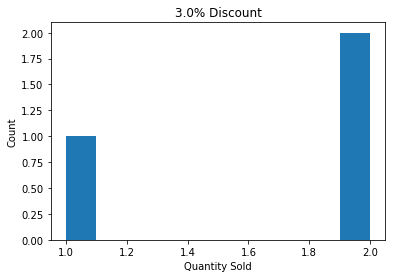

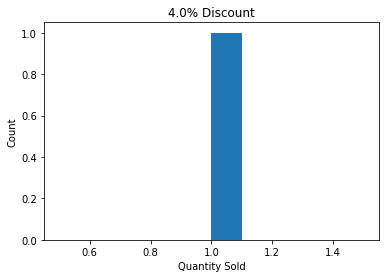

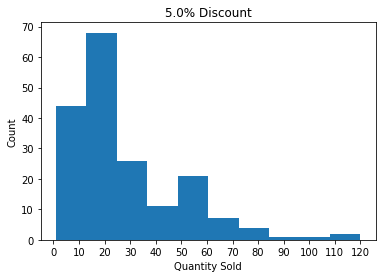

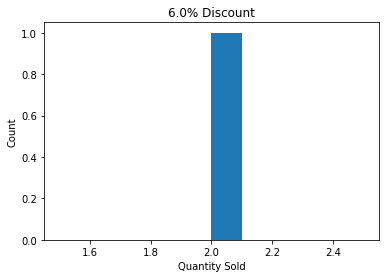

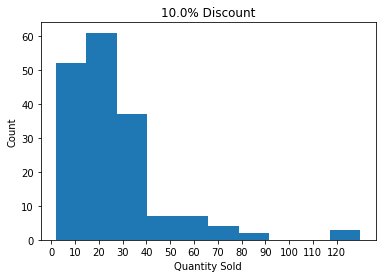

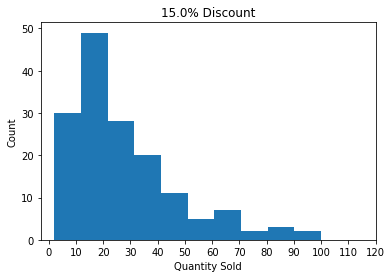

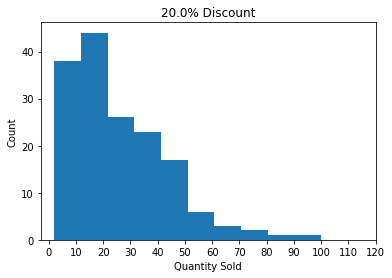

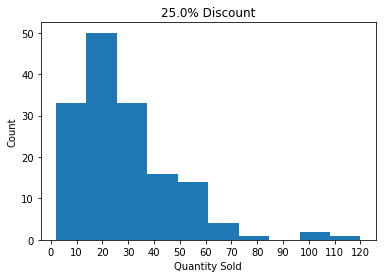

In [7]:
discounts=df1.Discount.unique()
discounts.sort()
for discount in discounts:
    plt.hist(df1.loc[df1.Discount==discount]['Quantity'])
    plt.xlabel('Quantity Sold')
    if discount in [0.0,0.05,0.1,0.15,0.2,0.25]:
        plt.xticks(range(0,130,10))
    plt.ylabel('Count')
    plt.title(f"{discount*100}% Discount")
    plt.show()

Right away, it looks like the data shifts to the right as the discount is applied, with the largest shift happening at a 25% discount.  However, none of the x-axes are scaled the same.

There are also some weird discount values that need to be investigated further (because 1, 2, 3, 4, and 6% discounts are uncommon discounts.)

But first, let's look at a particular product and see how many of that item was sold at each discount level.

In [8]:
def amounts_and_discounts(item):
    results={}
    item_df=df1.loc[df1.ProductId==item]
    for discount in discounts:
        quantity_sold=item_df.loc[item_df.Discount==discount]['Quantity'].sum()
        results[discount]=quantity_sold
    return results

item11=amounts_and_discounts(11)
item11

{0.0: 378,
 0.01: 0,
 0.02: 0,
 0.03: 0,
 0.04: 0,
 0.05: 30,
 0.06: 0,
 0.1: 120,
 0.15: 35,
 0.2: 68,
 0.25: 75}

So, for item #11, there were 378 sold with 0% discount and 75 sold with a 25% discount.

Let's figure out a couple more and then graph them to see what it looks like.

In [9]:
item42=amounts_and_discounts(42)
item1=amounts_and_discounts(1)
item14=amounts_and_discounts(14)

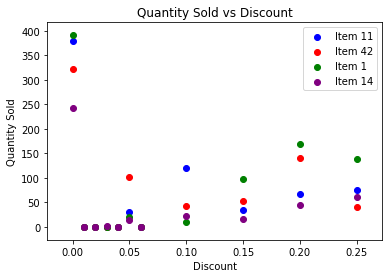

In [10]:
plt.scatter(item11.keys(),item11.values(),color='blue',label='Item 11')
plt.scatter(item42.keys(),item42.values(),color='red',label='Item 42')
plt.scatter(item1.keys(),item1.values(),color='green',label='Item 1')
plt.scatter(item14.keys(),item14.values(),color='purple', label='Item 14')
plt.xlabel('Discount')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold vs Discount')
plt.legend();

So, looking at this graph with a very small amount of data, it looks like there might be a peak when the discount is 20%.  We need to confirm that with some actual statistical analysis but this gives us some direction, at least.

To do that analysis, let's start by looking at whether things are discounted or not (and not worrying about the amount of the discount yet).

In [11]:
df1.loc[df1.Discount>0.0, "OnSale"] = 1
df1.loc[df1.Discount==0.0, "OnSale"] = 0
df1.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,OrderDate,ProductName,CategoryId,QuantityPerUnit,CategoryName,OnSale
0,10248,11,14.0,12,0.0,VINET,2012-07-04,Queso Cabrales,4,1 kg pkg.,Dairy Products,0.0
1,10248,42,9.8,10,0.0,VINET,2012-07-04,Singaporean Hokkien Fried Mee,5,32 - 1 kg pkgs.,Grains/Cereals,0.0
2,10248,72,34.8,5,0.0,VINET,2012-07-04,Mozzarella di Giovanni,4,24 - 200 g pkgs.,Dairy Products,0.0
3,10249,14,18.6,9,0.0,TOMSP,2012-07-05,Tofu,7,40 - 100 g pkgs.,Produce,0.0
4,10249,51,42.4,40,0.0,TOMSP,2012-07-05,Manjimup Dried Apples,7,50 - 300 g pkgs.,Produce,0.0


Ok, now a little bit of data cleaning (or at least, checking to see if the data needs cleaned).

In [12]:
df1.isna().sum()

OrderId            0
ProductId          0
UnitPrice          0
Quantity           0
Discount           0
CustomerId         0
OrderDate          0
ProductName        0
CategoryId         0
QuantityPerUnit    0
CategoryName       0
OnSale             0
dtype: int64

None of the categories have null/missing values, so that's good.  I'm also going to graph them to make sure there aren't any dummy values being used.

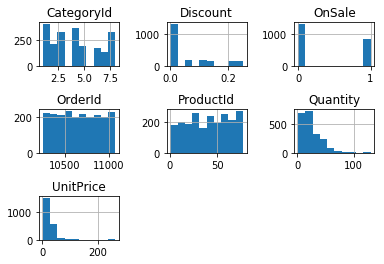

In [13]:
df1.hist();
plt.subplots_adjust(wspace=0.6,hspace=1)

Everything looks reasonable.  There don't seem to be any outliers - maybe unit price?  I'll check the descriptive stats to see if anything seems weird.

In [14]:
df1.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryId,OnSale
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.135499,0.388863
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.378567,0.487605
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,6.000000,1.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,8.000000,1.000000


The highest unit price is `$263.50`, which is a lot larger than the 75th percentile price of `$32`.  I'm curious what product that's for so I'm going to check that out quickly.  I also want to investigate the max quantity to see what that was for.  

In [15]:
df1.loc[df1.UnitPrice==df1.UnitPrice.max()]

,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,OrderDate,ProductName,CategoryId,QuantityPerUnit,CategoryName,OnSale
713,10518,38,263.5,15,0.00,TORTU,2013-04-25,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0
782,10540,38,263.5,30,0.00,QUICK,2013-05-19,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0
785,10541,38,263.5,4,0.10,HANAR,2013-05-19,Côte de Blaye,1,12 - 75 cl bottles,Beverages,1.0
971,10616,38,263.5,15,0.05,GREAL,2013-07-31,Côte de Blaye,1,12 - 75 cl bottles,Beverages,1.0
1115,10672,38,263.5,15,0.10,BERGS,2013-09-17,Côte de Blaye,1,12 - 75 cl bottles,Beverages,1.0
1403,10783,38,263.5,5,0.00,HANAR,2013-12-18,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0
1459,10805,38,263.5,10,0.00,THEBI,2013-12-30,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0
1483,10816,38,263.5,30,0.05,GREAL,2014-01-06,Côte de Blaye,1,12 - 75 cl bottles,Beverages,1.0
1486,10817,38,263.5,30,0.00,KOENE,2014-01-06,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0
1511,10828,38,263.5,2,0.00,RANCH,2014-01-13,Côte de Blaye,1,12 - 75 cl bottles,Beverages,0.0


So, Côte de Blaye has a unit price of `$263.50`.   After some quick googling, I found out that it's a wine (although I have no idea what particular wine it is as Côte de Blaye is a region/winery that produces many different types of wine).  According to the search results, most of the bottles go for around `$20` in 2019 (so they probably would've been cheaper in 2013/2014 when this data was collected).  I also see that the quantity per unit sold is actually 12 bottles so each bottle would cost about 263.50/12 = `$21.96`.  Seems completely reasonable.

The next thing I want to check out is the quantity.  The max was 130 with the 75th percentile being 30.

In [16]:
df1.loc[df1.Quantity==df1.Quantity.max()]

,OrderId,ProductId,UnitPrice,Quantity,Discount,CustomerId,OrderDate,ProductName,CategoryId,QuantityPerUnit,CategoryName,OnSale
1363,10764,39,18.00,130,0.1,ERNSH,2013-12-03,Chartreuse verte,1,750 cc per bottle,Beverages,1.0
2120,11072,64,33.25,130,0.0,ERNSH,2014-05-05,Wimmers gute Semmelknödel,5,20 bags x 4 pieces,Grains/Cereals,0.0


First, I notice that both orders were from the same customer, so that makes it seem more reasonable.  These people must just need a lot of stuff.  However, they're different items (different categories, even) so that seems a little strange.  I have no idea what either one of those things is so I'm off to google again.

I'm back!

Chartreuse verte is a liqueur and Wimmers gute Semmelknödel is some sort of bread dumpling.  Nothing seems particularly strange about either one of these orders, aside from the large number of units ordered.  I'm going to check out what else that customer has ordered though, to see if they often get larger quantities of things.

In [17]:
df1.loc[df1.CustomerId=='ERNSH']['Quantity'].describe()

count    102.000000
mean      44.539216
std       30.384556
min        4.000000
25%       21.000000
50%       35.500000
75%       65.000000
max      130.000000
Name: Quantity, dtype: float64

They do appear to buy larger numbers of products than the rest of the population.  130 is probably not unreasonable.

In [18]:
(df1.loc[df1.CustomerId=='ERNSH']['Quantity']>=100).sum()

8

They've ordered over 100 units of a product 8 times so 130 seems reasonable.

The last thing I need to check before doing a hypothesis test is the normality of the distributions.  I'll do this by looking at a distribution plot. (If it's obviously not normal, I don't need to do further tests.  If it looks like it could be normal, I'll follow up with a QQ plot.)

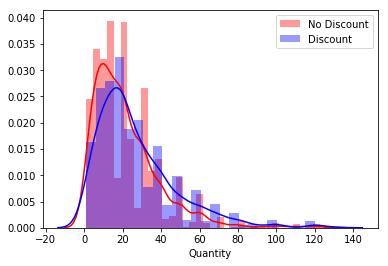

In [19]:
sns.distplot(df1[df1['OnSale']==0]['Quantity'],color='red',label='No Discount')
sns.distplot(df1[df1['OnSale']==1]['Quantity'],color='blue',label='Discount')
plt.legend();

Yeah, those aren't normal.  They're both skewed right so, to make them normal, I'm going to take a bunch of samples and find the means of each one of those samples.

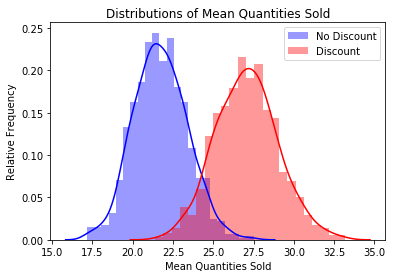

In [20]:
def get_sample_mean(group,n):
    group_sample=group.sample(n)
    group_mean=group_sample.mean()
    
    return group_mean

def sample_means(group,sample_size,number_of_samples):
    means=[]
    i=0
    while i <= number_of_samples:
        one_mean=get_sample_mean(group,sample_size)
        means.append(one_mean)
        i+=1
    return means

group1 = df1.loc[df1.OnSale==0.0]['Quantity']
group2 = df1.loc[df1.OnSale==1.0]['Quantity']

no_sale_means=sample_means(group1,100,1000)
yes_sale_means=sample_means(group2,100,1000)
sns.distplot(no_sale_means,color='blue',label='No Discount')
sns.distplot(yes_sale_means,color='red',label='Discount')
plt.xlabel('Mean Quantities Sold')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Mean Quantities Sold')
plt.legend();

Much better. Since they're both approximately normal now, let's do some hypothesis testing.

### Hypotheses

**Null Hypothesis**: Discounts decrease or do not change the quantity of items sold.  
**Alternative Hypothesis**: Discounts increase the quantity of items sold.

And, in math:  
$H_0: \mu<=23.813$  
$H_1: \mu>23.813$

Some other important things:  
* This is a one-tail test
* Alpha: 0.05 
* Power: 0.8  

It's nice to have a larger power but, in this case, it's probably better to have a smaller alpha. From a business standpoint, it's probably more profitable to erroneously reject the null hypothesis than it is to be wrong about not rejecting it.  In other words, if discounts don't increase the quantity sold but we think they do and then offer a discount, we're losing money.  If discounts do increase the quantity sold, but we think they don't, we won't offer a discount - so, we won't sell extra but we also won't be decreasing the prices.  Depending on the effect size, the difference between regular quantities\*regular prices and increased quantities\*decreased prices may not be that big.

Here's an example using that fancy wine from before:  
If there's a 0% discount and we sell 10 bottles, our revenue is `$2635.00`.  
If there's a 10% discount and we want to make the same revenue, we'd need to sell 2635.00/(263.50\*0.9)=11.111111 bottles.  
If there's a 20% discount, we'd need to sell  2635.00/(263.50*0.8)=12.5 bottles.  

And that works for any price, not just the fancy expensive things.  
If there's a 0% discount and we sell 10 of something that costs x dollars, our revenue is 10x.  
If there's a 10% discount and we want to make the same revenue, we'd need to sell 10x/0.9x= 11.11111  
If there's a 20% discount and we want to make the same revenue, we'd need to sell 10x/0.8x= 12.5  

All of this is to say that we'd like to be able to detect a difference in sales of about 1 unit.

So, going back to Cohen's d, that means our effect size is:

In [21]:
def cohens_d(group1,group2):
    group1=np.array(group1)
    group2=np.array(group2)
    u1=group1.mean()
    u2=group2.mean()
    print(f'First group mean: {u1}, 2nd group mean: {u2}')
    n1=len(group1)
    n2=len(group2)
    v1=np.var(group1, ddof=1)
    v2=np.var(group2, ddof=1)
    s = np.sqrt(((n1-1)*v1 + (n2-1)*v2)/(n1+n2-2))
    print(f'Pooled standared deviation: {s}')
    d = (u1-u2)/s
    return d

In [22]:
d1=cohens_d(group1,group2)
abs(d1)

First group mean: 21.715261958997722, 2nd group mean: 27.10978520286396
Pooled standared deviation: 18.84367601793773


0.2862776476697576

So, for the original, non-normal data, Cohen's d is 0.286 which indicates a medium difference between them. Let's look at Cohen's d for the sample mean groups.

In [23]:
d2=cohens_d(yes_sale_means,no_sale_means)
abs(d2)

First group mean: 27.072847152847153, 2nd group mean: 21.72827172827173
Pooled standared deviation: 1.79901510495386


2.970834102425448

If we look at the distributions of the sample means for each group, Cohen's d shoots up to 3, which is crazy-large.  There's definitely a difference between these two distributions.  Let's do a t-test to confirm.

In [24]:
t,p=stats.ttest_ind(yes_sale_means, no_sale_means, axis=0, equal_var=False)
p/2

0.0

Confirmed.  The p-value for the one-tailed test is less than 0.025 so we can reject the null hypothesis here and say that discounts do affect sales.  Our next question becomes: which discount level affects sales the most?

Before I do any serious statistical stuff, I'm going to look at some scatter plots. 

In [25]:
def mean_quantity_at_discount(item,discount):
    item_rows=df1.loc[df1.ProductId==item]
    mean_quantity=item_rows.loc[item_rows.Discount==discount]['Quantity'].mean()
    return mean_quantity
mean_quantity_at_discount(1,0.2)

42.5

In [26]:
items=df1.ProductId.unique()
discounts=[x for x in df1.Discount.unique()]
discounts.sort()

def quantity_at_each_discount(items,discounts):
    results={'items':[],0:[],0.01:[],0.02:[],0.03:[],0.04:[],0.05:[],0.06:[],0.1:[],0.15:[],0.2:[],0.25:[]}
    for item in items:
        results['items'].append(item)
        for discount in discounts:
            quant=mean_quantity_at_discount(item,discount)
            results[discount].append(quant)
    df=pd.DataFrame.from_dict(results)
    df.columns=[str(x) for x in results.keys()]
    return df

discount_df=quantity_at_each_discount(items,discounts)
discount_df.head()

,items,0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.15,0.2,0.25
0,11,15.120000,NaN,NaN,NaN,NaN,15.00,NaN,40.000000,35.000000,22.666667,18.75
1,42,17.833333,NaN,NaN,NaN,NaN,25.50,NaN,42.000000,26.000000,35.000000,40.00
2,72,19.677419,NaN,NaN,NaN,NaN,20.00,NaN,26.333333,27.500000,NaN,42.00
3,14,20.166667,NaN,NaN,1.0,NaN,15.00,NaN,11.500000,8.000000,22.500000,31.00
4,51,17.680000,NaN,NaN,NaN,NaN,46.25,NaN,6.000000,33.666667,34.000000,26.00


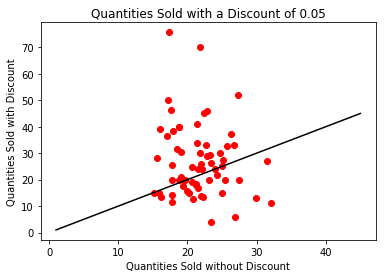

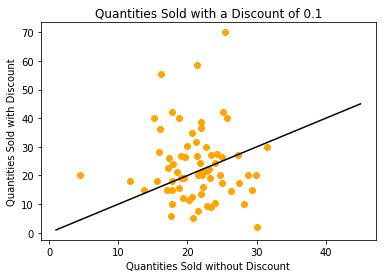

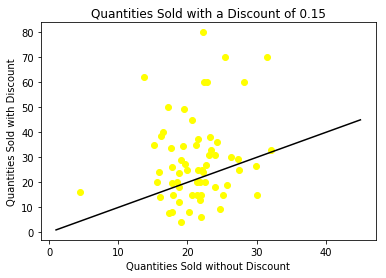

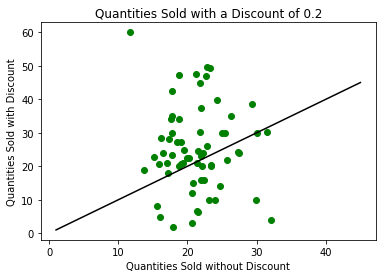

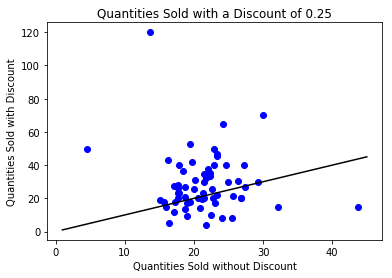

In [27]:
i=0
disc=[0.05,0.1,0.15,0.2,0.25]
colors=['red','orange','yellow','green','blue','purple','black','gray','maroon','teal','gold']
while i<=4:
    plt.scatter(discount_df['0'],discount_df[str(disc[i])],color=colors[i])
    plt.plot([1,45],[1,45],color='black')
    plt.ylabel("Quantities Sold with Discount")
    plt.xlabel('Quantities Sold without Discount')
    plt.title(f'Quantities Sold with a Discount of {disc[i]}')
    plt.show()
    i+=1


If there was no difference between the discounted item and the un-discounted item, then all of the points would fall on the black lines (because it would sell the same quantity regardless of the discount, the x and y values would be the same).

Any points above/to the left of the line indicate that the item sold more when it had a discount.  For example, if the point on the graph is (20,40), that means the number sold without a discount was 20 and the number sold with a discount was 40, so the point would be above the y=x line.

Any points below/to the right of the line indicate that the item sold less when it had a discount.  (Sometimes this happens with luxury items.  Also, items often go on sale before being discontinued - and they're often discontinued because the demand for them has gone down).

Anyway, looking at the graphs, nothing really stands out.  It would be more useful to have actual numbers (like, the proportion of points that were above the line).  So, that's what I'll figure out now.

In [28]:
for discount in discount_df.columns[2:]:
    percent_above=len(discount_df.loc[discount_df[discount]>discount_df['0']])/len(discount_df)
    percent_below=len(discount_df.loc[discount_df[discount]<discount_df['0']])/len(discount_df)
    print(f'discount: {round(float(discount)*100)}%, items that sold more: {round(percent_above*100,1)}%, items that sold less: {round(percent_below*100,1)}%')

discount: 1%, items that sold more: 0.0%, items that sold less: 1.3%
discount: 2%, items that sold more: 0.0%, items that sold less: 2.6%
discount: 3%, items that sold more: 0.0%, items that sold less: 3.9%
discount: 4%, items that sold more: 0.0%, items that sold less: 1.3%
discount: 5%, items that sold more: 48.1%, items that sold less: 32.5%
discount: 6%, items that sold more: 0.0%, items that sold less: 1.3%
discount: 10%, items that sold more: 42.9%, items that sold less: 45.5%
discount: 15%, items that sold more: 50.6%, items that sold less: 29.9%
discount: 20%, items that sold more: 51.9%, items that sold less: 29.9%
discount: 25%, items that sold more: 51.9%, items that sold less: 31.2%


So, based on that, I'd predict that a 20% discount gives the best return.  A high percentage of items sold more than expected and the number of items that sold less was minimized.  (20% also matches with my prediction from earlier, too.)

But statistics would be better.  So, I'll do an ANOVA test to see which group gives the highest mean.  But first, boxplots!

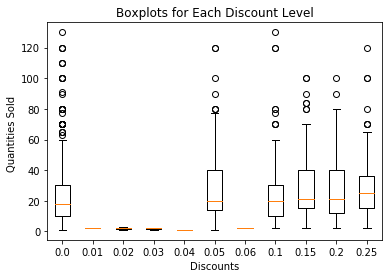

In [29]:
i=0
data=[]
for discount in discounts:
    data.append(df1.loc[df1.Discount==discount]['Quantity'])
plt.boxplot(data,labels=discounts)
plt.xlabel('Discounts')
plt.ylabel('Quantities Sold ')
plt.title('Boxplots for Each Discount Level')
plt.show();

There's a lot of overlap between the range of the boxplots which means that the data is all relatively similar.  I notice that the interquartile range gets bigger as discounts are applied so that means there's more variation with the quantities that are sold. We can also see that there's not much data for 1, 2, 3, 4, and 6% discounts so, for the ANOVA test, I'm going to disregard those groups.

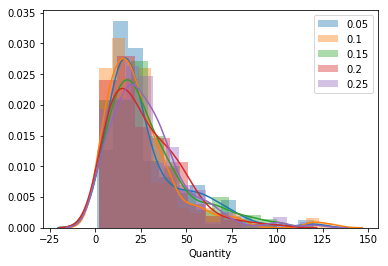

In [30]:
disc=[0.05,0.1,0.15,0.2,0.25]
for discount in disc:
    sns.distplot(df1[df1['Discount']==discount]['Quantity'],label=discount)
plt.legend();

Those are also not normal distributions so let's go back to getting sample means.

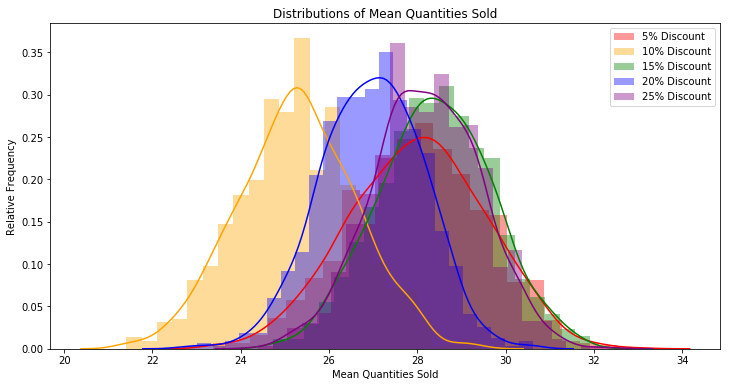

In [31]:
disc=[0.05,0.1,0.15,0.2,0.25]

five_percent_means=sample_means(df1[df1['Discount']==0.05]['Quantity'],100,1000)
ten_percent_means=sample_means(df1[df1['Discount']==0.10]['Quantity'],100,1000)
fifteen_percent_means=sample_means(df1[df1['Discount']==0.15]['Quantity'],100,1000)
twenty_percent_means=sample_means(df1[df1['Discount']==0.20]['Quantity'],100,1000)
twenty_five_percent_means=sample_means(df1[df1['Discount']==0.25]['Quantity'],100,1000)

plt.figure(figsize=(12,6))
sns.distplot(five_percent_means,color='red',label='5% Discount')
sns.distplot(ten_percent_means,color='orange',label='10% Discount')
sns.distplot(fifteen_percent_means,color='green',label='15% Discount')
sns.distplot(twenty_percent_means,color='blue',label='20% Discount')
sns.distplot(twenty_five_percent_means,color='purple',label='25% Discount')

plt.xlabel('Mean Quantities Sold')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Mean Quantities Sold')
plt.legend();

Those look more normal.

In [32]:
group1=no_sale_means
group2=five_percent_means
group3=ten_percent_means
group4=fifteen_percent_means
group5=twenty_percent_means
group6=twenty_five_percent_means

In [33]:
v=np.concatenate([group1,group2,group3,group4,group5,group6])
labels=['NoDiscount']*len(group1)+['5Percent']*len(group2)+['10Percent']*len(group3)+['15Percent']*len(group4)+['20Percent']*len(group5)+['25Percent']*len(group6)

df1_means=pd.DataFrame(labels,v)
df1_means.reset_index(inplace=True)
df1_means.columns=['MeanQuantity','Discount']
df1_means.head()

,MeanQuantity,Discount
0,21.57,NoDiscount
1,23.44,NoDiscount
2,20.92,NoDiscount
3,20.28,NoDiscount
4,19.14,NoDiscount


In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'MeanQuantity ~ C(Discount)'
lm = ols(formula, df1_means).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq      df            F  PR(>F)
C(Discount)  33267.245444     5.0  3534.142691     0.0
Residual     11295.722336  6000.0          NaN     NaN


Because the p-value (`PR(>F)`) is so small, there's definitely a difference between the discount levels.  However, we have no idea which one is different so I need to do a pair-wise comparison to figure it out. 

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print(pairwise_tukeyhsd(v,labels,0.05))

 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2   meandiff  lower   upper  reject
----------------------------------------------------
10Percent 15Percent   3.1279   2.9531  3.3027  True 
10Percent 20Percent   1.695    1.5201  1.8698  True 
10Percent 25Percent   2.9244   2.7496  3.0993  True 
10Percent  5Percent   2.717    2.5422  2.8919  True 
10Percent NoDiscount -3.5509  -3.7257 -3.3761  True 
15Percent 20Percent  -1.4329  -1.6077 -1.2581  True 
15Percent 25Percent  -0.2035  -0.3783 -0.0286  True 
15Percent  5Percent  -0.4108  -0.5857  -0.236  True 
15Percent NoDiscount -6.6788  -6.8536 -6.5039  True 
20Percent 25Percent   1.2295   1.0546  1.4043  True 
20Percent  5Percent   1.0221   0.8472  1.1969  True 
20Percent NoDiscount -5.2459  -5.4207  -5.071  True 
25Percent  5Percent  -0.2074  -0.3822 -0.0326  True 
25Percent NoDiscount -6.4753  -6.6501 -6.3005  True 
 5Percent NoDiscount -6.2679  -6.4428 -6.0931  True 
----------------------------------------------

So, it looks like there's a difference between no discount and a discount.  Any discount level will increase the quantity sold.  The biggest difference occured between 15% and No Discount so, it looks like 15% is probably the best discount to offer, with 25% coming in a close second. 

### Conclusion

To maximize the quantity sold and the revenue coming in, a 15% discount should be offered.  More analysis should be done to determine on which items this discount would be most effective.  Luxury item sales may suffer from having a discount applied so it may not be useful to apply this discount across the board.  Also, some investigation is needed to determine at what intervals and durations 15% discounts should be offered.  They may lose their effectiveness if offered continuously.

## Hypothesis Test 2: Seasons and Quantities Sold

For this test, I'm interested in determining if more items are sold during certain seasons.  First, we'll gather the necessary data.

In [36]:
c.execute("""SELECT d.*, o.OrderDate, p.ProductName
             From OrderDetail d
             JOIN [Order] o on o.Id=d.OrderId
             JOIN Product p on d.ProductId=p.Id""")
df2=pd.DataFrame(c.fetchall())
df2.columns=[x[0] for x in c.description]
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,ProductName
0,10248/11,10248,11,14.0,12,0.0,2012-07-04,Queso Cabrales
1,10248/42,10248,42,9.8,10,0.0,2012-07-04,Singaporean Hokkien Fried Mee
2,10248/72,10248,72,34.8,5,0.0,2012-07-04,Mozzarella di Giovanni
3,10249/14,10249,14,18.6,9,0.0,2012-07-05,Tofu
4,10249/51,10249,51,42.4,40,0.0,2012-07-05,Manjimup Dried Apples


Then a little processing, to figure out what season each order falls into. 

In [37]:
type(df2.OrderDate[0])

str

The order date is currently a string so I'm going to change it to a datetime variable and then single out the month so that I can determine the season.

In [38]:
df2["OrderDate"] = pd.to_datetime(df2["OrderDate"])
type(df2.OrderDate[0])

pandas._libs.tslibs.timestamps.Timestamp

In [39]:
df2.OrderDate[0].month

7

In [40]:
df2['Month']=[x.month for x in df2.OrderDate]

In [41]:
df2.loc[(df2.Month>=1)&(df2.Month<=2)|(df2.Month==12),'Season']='Winter'
df2.loc[(df2.Month>=3)&(df2.Month<=5),'Season']='Spring'
df2.loc[(df2.Month>=6)&(df2.Month<=8),'Season']='Summer'
df2.loc[(df2.Month>=9)&(df2.Month<=11),'Season']='Fall'
df2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderDate,ProductName,Month,Season
0,10248/11,10248,11,14.0,12,0.0,2012-07-04,Queso Cabrales,7,Summer
1,10248/42,10248,42,9.8,10,0.0,2012-07-04,Singaporean Hokkien Fried Mee,7,Summer
2,10248/72,10248,72,34.8,5,0.0,2012-07-04,Mozzarella di Giovanni,7,Summer
3,10249/14,10249,14,18.6,9,0.0,2012-07-05,Tofu,7,Summer
4,10249/51,10249,51,42.4,40,0.0,2012-07-05,Manjimup Dried Apples,7,Summer


And now some boxplots, to get an idea of how much is sold in each season.

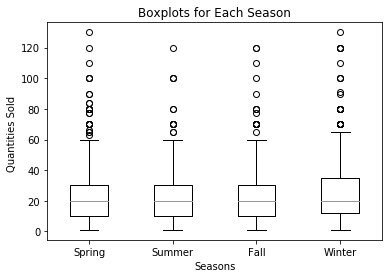

In [42]:
i=0
data=[]
seasons=['Spring','Summer','Fall','Winter']
for season in seasons:
    data.append(df2.loc[df2.Season==season]['Quantity'])
plt.boxplot(data,labels=seasons)
plt.xlabel('Seasons')
plt.ylabel('Quantities Sold ')
plt.title('Boxplots for Each Season')
plt.show();

They look mostly the same, with Winter potentially having higher quantities sold.  They look skewed so let's check it out.

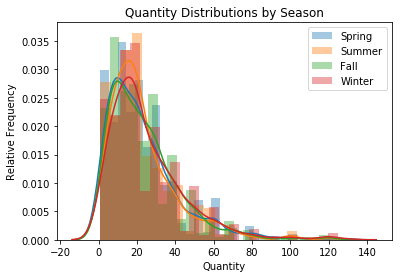

In [43]:
for season in seasons:
    sns.distplot(df2.loc[df2.Season==season]['Quantity'],label=season)
plt.ylabel('Relative Frequency')
plt.title('Quantity Distributions by Season')
plt.legend();

Definitely not normal.  Let's trying doing a log transformation on them this time to see what happens.

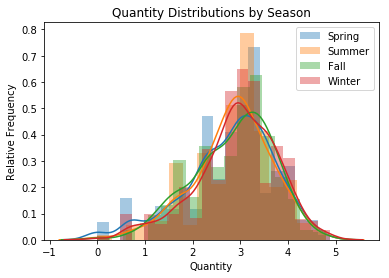

In [44]:
for season in seasons:
    sns.distplot(np.log(df2.loc[df2.Season==season]['Quantity']),label=season)
plt.ylabel('Relative Frequency')
plt.title('Quantity Distributions by Season')
plt.legend();

That looks a lot more normal. I'm going to try doing t-tests with the log-transformed distributions.

In [45]:
df2['Quantity']=np.log(df2['Quantity'])

### Hypotheses

Null Hypothesis: The same quantity is sold in every season.  
Alternative Hypothesis: There is at least one season during the quantity of items sold is higher.

And, in math:  
$H_0:\mu_{summer} = \mu_{spring} = \mu_{winter} = \mu_{fall}$ (all the means are equal)   
$H_1:\mu_{summer} \neq \mu_{spring}$ or $\mu_{summer} \neq \mu_{winter}$ or $\mu_{summer}\neq\mu_{fall}$ or $\mu_{spring}\neq\mu_{winter}$ or $\mu_{spring}\neq\mu_{fall}$ or $\mu_{winter}\neq\mu_{fall}$  (at least one mean is different)

Some other important things:  

This is a two-tail test and alpha is 0.05.

In [46]:
df2.Season.value_counts()

Spring    671
Winter    633
Fall      486
Summer    365
Name: Season, dtype: int64

Interesting to note:  There appear to be more orders in Spring/Winter than in Summer.  That could be investigated further, too.

In [47]:
formula = 'Quantity ~ C(Season)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df         F    PR(>F)
C(Season)     6.893812     3.0  3.016602  0.028856
Residual   1638.553192  2151.0       NaN       NaN


Yeah, the p-value is lower that alpha so looks like the seasons are not all the same.

In [48]:
group1=df2.loc[df2.Season=='Spring']['Quantity']
group2=df2.loc[df2.Season=='Summer']['Quantity']
group3=df2.loc[df2.Season=='Fall']['Quantity']
group4=df2.loc[df2.Season=='Winter']['Quantity']
v=np.concatenate([group1,group2,group3,group4])
labels=['Spring']*len(group1)+['Summer']*len(group2)+['Fall']*len(group3)+['Winter']*len(group4)
print(pairwise_tukeyhsd(v,labels,0.05))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 Fall  Spring  -0.076  -0.2096 0.0577 False 
 Fall  Summer -0.0166   -0.172 0.1388 False 
 Fall  Winter  0.0689  -0.0665 0.2042 False 
Spring Summer  0.0594  -0.0866 0.2053 False 
Spring Winter  0.1449   0.0205 0.2692  True 
Summer Winter  0.0855   -0.062 0.233  False 
--------------------------------------------


For further confirmation, the pairwise comparison also shows that all the seasons are the same, as far as quantities sold goes.  The biggest difference appears to be between Spring and Winter.

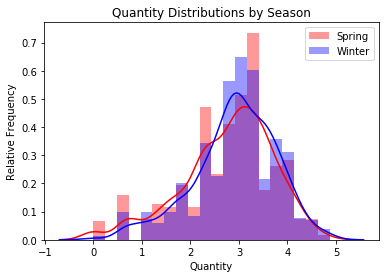

In [49]:
sns.distplot(group1,color='red',label='Spring')
sns.distplot(group4,color='blue',label='Winter')
plt.ylabel('Relative Frequency')
plt.title('Quantity Distributions by Season')
plt.legend();

There doesn't appear to be much of a difference so let's figure out the effect size.

In [50]:
cohens_d(group1,group4)

First group mean: 2.7758796872452307, 2nd group mean: 2.9207395557676117
Pooled standared deviation: 0.8978244827480028


-0.16134542029752108

That's a relatively small effect size so there may be a minor difference between Winter and Spring.  The seasons mostly have the same quantities of items sold though.  It might be that more sales are offered during Winter which increases the quantity sold (and so the discount -- not the season -- is affecting the sales).  Let's check it out.

In [51]:
c.execute("""SELECT d.Quantity,d.Discount, o.OrderDate
             FROM [Order] o
             JOIN OrderDetail d
             on o.Id=d.OrderId
             """)
df2a=pd.DataFrame(c.fetchall())
df2a.columns = [x[0] for x in c.description]
df2a.head()

,Quantity,Discount,OrderDate
0,12,0.0,2012-07-04
1,10,0.0,2012-07-04
2,5,0.0,2012-07-04
3,9,0.0,2012-07-05
4,40,0.0,2012-07-05


In [53]:
df2a["OrderDate"] = pd.to_datetime(df2a["OrderDate"])
df2a['Month']=[x.month for x in df2a.OrderDate]
df2a.loc[(df2a.Month>=1)&(df2a.Month<=2)|(df2a.Month==12),'Season']='Winter'
df2a.loc[(df2a.Month>=3)&(df2a.Month<=5),'Season']='Spring'
df2a.loc[(df2a.Month>=6)&(df2a.Month<=8),'Season']='Summer'
df2a.loc[(df2a.Month>=9)&(df2a.Month<=11),'Season']='Fall'
df2a.loc[df2a.Discount>0.0, "OnSale"] = 1
df2a.loc[df2a.Discount==0.0, "OnSale"] = 0
df2a.head()

,Quantity,Discount,OrderDate,Month,Season,OnSale
0,12,0.0,2012-07-04,7,Summer,0.0
1,10,0.0,2012-07-04,7,Summer,0.0
2,5,0.0,2012-07-04,7,Summer,0.0
3,9,0.0,2012-07-05,7,Summer,0.0
4,40,0.0,2012-07-05,7,Summer,0.0


In [54]:
df2a.drop(['OrderDate','Discount','Month','Quantity'],axis=1,inplace=True)

In [55]:
group1=df2a.loc[df2a.Season=='Spring']['OnSale']
group2=df2a.loc[df2a.Season=='Summer']['OnSale']
group3=df2a.loc[df2a.Season=='Fall']['OnSale']
group4=df2a.loc[df2a.Season=='Winter']['OnSale']

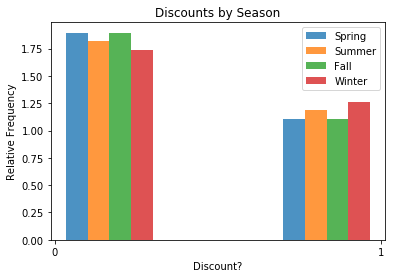

In [56]:
plt.hist([group1,group2,group3,group4],label=['Spring','Summer','Fall','Winter'], alpha=0.8,density=True,bins=3)
plt.xticks([0,1])
plt.xlabel('Discount?')
plt.ylabel('Relative Frequency')
plt.title('Discounts by Season')
plt.legend()
plt.show();

From the graph above, we can see that there are indeed more discounts (relatively speaking) during Winter than the other seasons.  On the left, the Winter bar is below the other three bars but on the right, the Winter bar shoots up above all of them, indicating that the number of items sold with a discount is higher in Winter.  This would likely explain the difference in sales between the seasons.  (We also see a similar increase with Summer rising above Spring and Fall.)

### Conclusion

There isn't a significant difference between seasons with respect to the number of items sold.  More discounts are offered during the winter, which causes Winter to have an increased amount of items sold.  It could be worthwhile to experiment with offering discounts during different seasons and collecting data so that it can be determined when sales are most effective.

## Hypothesis 3: Product Category vs Order Fulfillment Time

For this test, I'll be looking to see if there's a category of products that ships slower than the others.  First, I've got to get the relevant data.

In [57]:
c.execute("""SELECT p.ProductName,c.CategoryName,o.OrderDate,o.ShippedDate
             FROM Product p
             JOIN Category c on c.Id=p.CategoryId
             JOIN OrderDetail d on p.Id=d.ProductId
             JOIN [Order] o on o.Id=d.OrderId
             """)
df3=pd.DataFrame(c.fetchall())
df3.columns=[x[0] for x in c.description]
df3.head()

,ProductName,CategoryName,OrderDate,ShippedDate
0,Queso Cabrales,Dairy Products,2012-07-04,2012-07-16
1,Singaporean Hokkien Fried Mee,Grains/Cereals,2012-07-04,2012-07-16
2,Mozzarella di Giovanni,Dairy Products,2012-07-04,2012-07-16
3,Tofu,Produce,2012-07-05,2012-07-10
4,Manjimup Dried Apples,Produce,2012-07-05,2012-07-10


Now, I need to figure out the time between the shipping date and the order date.  First, I've got to make sure both of those columns are date-time objects.

In [58]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
ProductName     2155 non-null object
CategoryName    2155 non-null object
OrderDate       2155 non-null object
ShippedDate     2082 non-null object
dtypes: object(4)
memory usage: 67.4+ KB


And of course they aren't, so I'll change them to date-time.

In [59]:
df3["OrderDate"] = pd.to_datetime(df3["OrderDate"])
df3["ShippedDate"] = pd.to_datetime(df3["ShippedDate"])
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
ProductName     2155 non-null object
CategoryName    2155 non-null object
OrderDate       2155 non-null datetime64[ns]
ShippedDate     2082 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 67.4+ KB


Now, to figure out the processing time, I just need to subtract the order date from the shipping date.

In [60]:
(df3.ShippedDate[0]-df3.OrderDate[0]).days

12

In [61]:
df3['ProcessTime']=[(df3.ShippedDate[x]-df3.OrderDate[x]).days for x in df3.index]
df3.head()

,ProductName,CategoryName,OrderDate,ShippedDate,ProcessTime
0,Queso Cabrales,Dairy Products,2012-07-04,2012-07-16,12.0
1,Singaporean Hokkien Fried Mee,Grains/Cereals,2012-07-04,2012-07-16,12.0
2,Mozzarella di Giovanni,Dairy Products,2012-07-04,2012-07-16,12.0
3,Tofu,Produce,2012-07-05,2012-07-10,5.0
4,Manjimup Dried Apples,Produce,2012-07-05,2012-07-10,5.0


In [62]:
df3.isna().sum()

ProductName      0
CategoryName     0
OrderDate        0
ShippedDate     73
ProcessTime     73
dtype: int64

There were 73 rows that don't have "shipped dates" and thus we can't calculate a processing time (from ordering to shipping) for them.  Let's drop those rows.  (This is another area where we could do more investigation - why weren't those orders shipped? - but that's outside the scope of this project.)

In [63]:
rows_to_drop=df3.loc[df3.ShippedDate.isna()].index
df3.drop(rows_to_drop,inplace=True)

Now that those rows are dropped, let's look at the categories and figure out the processing time for each category of items.

In [64]:
df3.CategoryName.value_counts()

Beverages         389
Dairy Products    355
Confections       324
Seafood           319
Condiments        207
Grains/Cereals    191
Meat/Poultry      169
Produce           128
Name: CategoryName, dtype: int64

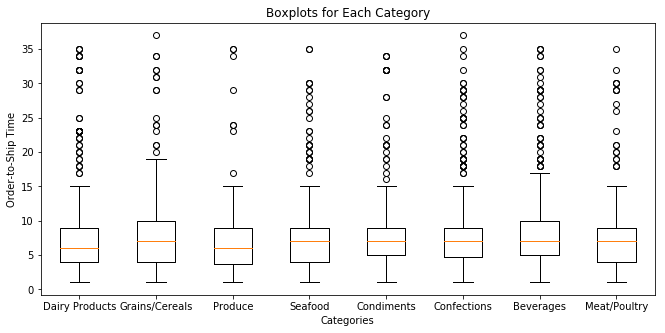

In [65]:
i=0
data=[]
categories=df3.CategoryName.unique()
for category in categories:
    data.append(df3.loc[df3.CategoryName==category]['ProcessTime'])

plt.figure(figsize=(11,5))
plt.boxplot(data,labels=categories)
plt.xlabel('Categories')
plt.ylabel('Order-to-Ship Time')
plt.title('Boxplots for Each Category')
plt.show();

Surprise! None of them are normally distributed.  They all look about the same, too. I'm going to do the same thing I did in the first hypothesis test - I'll sample each one of the categories a bunch of times and find the mean of each sample. 

In [66]:
dairy_means=sample_means(df3[df3['CategoryName']==categories[0]]['ProcessTime'],100,1000)
grains_means=sample_means(df3[df3['CategoryName']==categories[1]]['ProcessTime'],100,1000)
produce_means=sample_means(df3[df3['CategoryName']==categories[2]]['ProcessTime'],100,1000)
seafood_means=sample_means(df3[df3['CategoryName']==categories[3]]['ProcessTime'],100,1000)
condiments_means=sample_means(df3[df3['CategoryName']==categories[4]]['ProcessTime'],100,1000)
confections_means=sample_means(df3[df3['CategoryName']==categories[5]]['ProcessTime'],100,1000)
beverages_means=sample_means(df3[df3['CategoryName']==categories[6]]['ProcessTime'],100,1000)
meat_means=sample_means(df3[df3['CategoryName']==categories[7]]['ProcessTime'],100,1000)
all_the_means=[dairy_means,grains_means,produce_means,seafood_means,condiments_means,confections_means,beverages_means,meat_means]

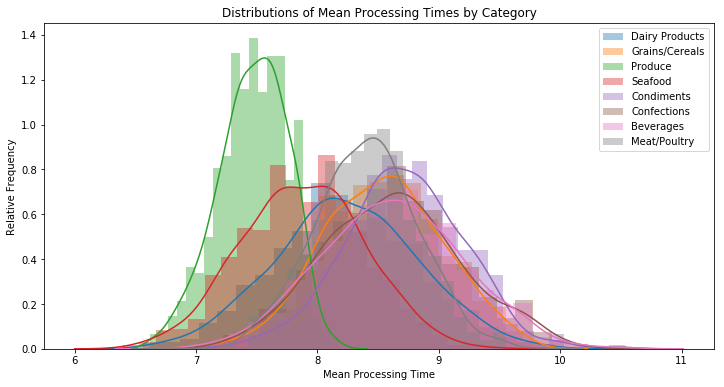

In [67]:
plt.figure(figsize=(12,6))
i=0
for mean in all_the_means:
    sns.distplot(mean,label=categories[i])
    i+=1

plt.xlabel('Mean Processing Time')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Mean Processing Times by Category')
plt.legend();

Interesting.  So, it looks like produce and seafood may have a shorter order-to-ship time than the other categories.  Condiments may take the longest.  That's reassuring to see.  Let's do an ANOVA test to see if they're actually different, though.

### Hypotheses

Null Hypothesis, $H_0$: There is no difference in processing time between the different categories.  
Alternate Hypothesis, $H_1$: There is a difference in processing time for at least one category.

This is a two-tail test.  Alpha is 0.05.

In [68]:
group0=dairy_means
group1=grains_means
group2=produce_means
group3=seafood_means
group4=condiments_means
group5=confections_means
group6=beverages_means
group7=meat_means

v=np.concatenate([group0,group1,group2,group3,group4,group5,group6,group7])
labels=[categories[0]]*len(group0)+[categories[1]]*len(group1)+[categories[2]]*len(group2)+[categories[3]]*len(group3)+[categories[4]]*len(group4)+[categories[5]]*len(group5)+[categories[6]]*len(group6)+[categories[7]]*len(group7)
index=list(range(len(v)))

In [69]:
df3_means=pd.DataFrame(labels,v)
df3_means.reset_index(inplace=True)
df3_means.columns=['ProcessTime','CategoryName']
df3_means.head()

,ProcessTime,CategoryName
0,9.15,Dairy Products
1,8.57,Dairy Products
2,8.75,Dairy Products
3,7.49,Dairy Products
4,7.99,Dairy Products


In [70]:
formula = 'ProcessTime ~ C(CategoryName)'
lm = ols(formula, df3_means).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df           F  PR(>F)
C(CategoryName)  1305.786454     7.0  748.879305     0.0
Residual         1992.747517  8000.0         NaN     NaN


So, it looks like there is a difference between the categories (since the p-value is less than 0.05).  So now I'll do a pairwise comparison:

In [71]:
print(pairwise_tukeyhsd(v,labels,0.05))

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
  Beverages      Condiments    0.1002   0.0325  0.1678  True 
  Beverages     Confections    0.0038  -0.0638  0.0714 False 
  Beverages    Dairy Products -0.3748  -0.4425 -0.3072  True 
  Beverages    Grains/Cereals -0.0736  -0.1412 -0.0059  True 
  Beverages     Meat/Poultry  -0.2113  -0.2789 -0.1437  True 
  Beverages       Produce     -1.1426  -1.2103  -1.075  True 
  Beverages       Seafood     -0.7329  -0.8006 -0.6653  True 
  Condiments    Confections   -0.0964   -0.164 -0.0288  True 
  Condiments   Dairy Products  -0.475  -0.5426 -0.4074  True 
  Condiments   Grains/Cereals -0.1737  -0.2414 -0.1061  True 
  Condiments    Meat/Poultry  -0.3115  -0.3791 -0.2438  True 
  Condiments      Produce     -1.2428  -1.3104 -1.1752  True 
  Condiments      Seafood     -0.8331  -0.9007 -0.7655  True 
 Confect

It looks like beverages and confections do not have different processing times.  Beverages and grains/cereals also do not seem to have different processing times.  Looking at the `meandiff` column above, it appears that produce has the biggest difference from the other categories.  

### Conclusion

Produce items tend to have a faster processing time than other categories.  Beverages seem to take longer to process.  It could be useful to determine the processing time of orders that contain both produce and beverages compared to orders that only contain one or the other.  If beverages take longer to ship than the other categories, it may be worth shipping them separately (to increase customer satisfaction) or examining and improving current methods to shorten the processing time for beverages.

## Hypothesis Test 4: Managers and Revenue

Do employees under different managers bring in different amounts of revenue? First, as usual, let's gather the data.

In [72]:
c.execute("""SELECT e.Id as EmpId,e.LastName,e.FirstName,e.ReportsTo,o.Id as OrderId,o.CustomerId,d.ProductId,d.UnitPrice,d.Quantity,d.Discount
             FROM Employee e
             JOIN [Order] o on o.EmployeeId=e.Id
             JOIN OrderDetail d on o.Id=d.OrderId""")
df4=pd.DataFrame(c.fetchall())
df4.columns=[x[0] for x in c.description]
df4.head()

,EmpId,LastName,FirstName,ReportsTo,OrderId,CustomerId,ProductId,UnitPrice,Quantity,Discount
0,5,Buchanan,Steven,2.0,10248,VINET,11,14.0,12,0.0
1,5,Buchanan,Steven,2.0,10248,VINET,42,9.8,10,0.0
2,5,Buchanan,Steven,2.0,10248,VINET,72,34.8,5,0.0
3,6,Suyama,Michael,5.0,10249,TOMSP,14,18.6,9,0.0
4,6,Suyama,Michael,5.0,10249,TOMSP,51,42.4,40,0.0


And let's see how many different employees there are.

In [73]:
df4['EmpId'].value_counts()

4    420
1    345
3    321
8    260
2    241
7    176
6    168
5    117
9    107
Name: EmpId, dtype: int64

It looks like there are only 9 different employees.  That's pretty good for an international company.  I wonder if they have a lot of contract workers?

In [74]:
df4.ReportsTo.value_counts()

2.0    1463
5.0     451
Name: ReportsTo, dtype: int64

There appear to be two managers: Employee Id #2 and Employee Id #5.

In [75]:
df4.loc[df4.EmpId==5][['LastName','FirstName','ReportsTo']].head(1)

,LastName,FirstName,ReportsTo
0,Buchanan,Steven,2.0


In [76]:
df4.loc[df4.EmpId==2][['LastName','FirstName','ReportsTo']].head(1)

,LastName,FirstName,ReportsTo
49,Fuller,Andrew,NaN


Employee #2 is Andrew Fuller and Employee #5 is Steven Buchanan. So, for our hypothesis test, let's see if Andrew's or Steven's employees sell more. Since Steven reports to Andrew, we'll do the hypothesis test without Steven's sales included in Andrew's team.

In [77]:
len(df4.OrderId.unique())

830

There are 830 total orders so for the first step, I'm going to calculate the total amount of revenue for each order. First, I'll write a function to calculate the total of a given order.

In [78]:
def order_total(order_number):
    indices=df4.loc[df4.OrderId==order_number].index
    total=0
    for index in indices:
        total+=df4.UnitPrice[index]*df4.Quantity[index]*(1-df4.Discount[index])
    return total

order_total(10248)

440.0

Order 10248 totaled to `$440`.  Now, I'll use that method to find the total for each order and I'll create a new list that has the employee, their manager, the order number, and the total of the order.

In [79]:
orders=df4.OrderId.unique()
data={'LastName':[],'FirstName':[],'ReportsTo':[],'OrderId':[],'OrderTotal':[]}
for order in orders:
    total=order_total(order)
    employee_last_name=df4.loc[df4.OrderId==order]['LastName'].unique()[0]
    employee_first_name=df4.loc[df4.OrderId==order]['FirstName'].unique()[0]
    manager=df4.loc[df4.OrderId==order]['ReportsTo'].unique()[0]
    data['LastName'].append(employee_last_name)
    data['FirstName'].append(employee_first_name)
    data['ReportsTo'].append(manager)
    data['OrderId'].append(order)
    data['OrderTotal'].append(total)

df4a=pd.DataFrame.from_dict(data)
df4a.head()

,LastName,FirstName,ReportsTo,OrderId,OrderTotal
0,Buchanan,Steven,2.0,10248,440.00
1,Suyama,Michael,5.0,10249,1863.40
2,Peacock,Margaret,2.0,10250,1552.60
3,Leverling,Janet,2.0,10251,654.06
4,Peacock,Margaret,2.0,10252,3597.90


In [80]:
df4.loc[df4.LastName=='Buchanan']['EmpId'].unique()

array([5], dtype=int64)

In [81]:
df4.loc[df4.LastName=='Fuller']['EmpId'].unique()

array([2], dtype=int64)

I'm going to move Steven and Andrew into their own groups and we can do a head-to-head competition with them later.  For right now though, I'm interested in their employees so I'm going to make two groups: one with Steven's employees and one with Andrew's.  There's only one Buchanan in this dataframe, so I don't need to worry about checking to make sure it's Steven.  They're all Steven.  (Similarly, the only Fuller is Andrew so I can just search by last name.)

In [82]:
team_andrew=df4a.loc[(df4a.ReportsTo==2)&(df4a.LastName!='Buchanan')]
team_steven=df4a.loc[df4a.ReportsTo==5]
steven=df4a.loc[df4a.LastName=='Buchanan']
andrew=df4a.loc[df4a.LastName=='Fuller']
print(f'Team Andrew has {len(team_andrew)} orders. Team Steven has {len(team_steven)} orders. Steven has {len(steven)} orders and Andrew has {len(andrew)}.')

Team Andrew has 510 orders. Team Steven has 182 orders. Steven has 42 orders and Andrew has 96.


So, right off the bat, Team Andrew has more sales but that could be for a number of reasons.  Maybe Andrew has more employees that report to him, maybe Andrew's team sells items individually to pump up their number of orders. We could investigate further, but let's focus on the average total for each order instead.

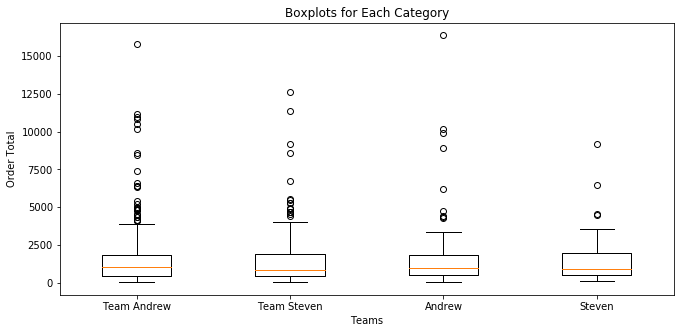

In [83]:
i=0
data=[]
categories=[team_andrew,team_steven, andrew, steven]
for category in categories:
    data.append(category['OrderTotal'])

plt.figure(figsize=(11,5))
plt.boxplot(data,labels=['Team Andrew','Team Steven', 'Andrew', 'Steven'])
plt.xlabel('Teams')
plt.ylabel('Order Total')
plt.title('Boxplots for Each Category')
plt.show();

The good news for Andrew and Steven is that both teams seem to be performing just as well as each other (and Andrew and Steven are neck-in-neck, too).  Let's do a t-test to see the actual numbers, though.  But first, of course, I need to normalize the data.

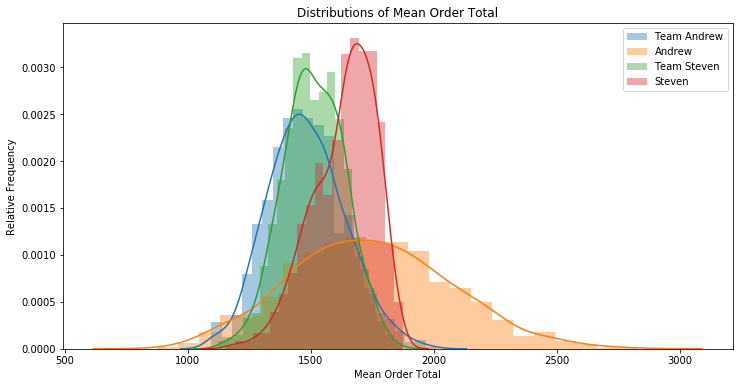

In [84]:
team_andrew_means=sample_means(team_andrew['OrderTotal'],100,1000)
team_steven_means=sample_means(team_steven['OrderTotal'],100,1000)
andrew_means=sample_means(andrew['OrderTotal'],35,1000)
steven_means=sample_means(steven['OrderTotal'],35,1000)

plt.figure(figsize=(12,6))
sns.distplot(team_andrew_means,label='Team Andrew')
sns.distplot(andrew_means,label='Andrew')
sns.distplot(team_steven_means,label='Team Steven')
sns.distplot(steven_means,label='Steven')

plt.xlabel('Mean Order Total')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Mean Order Total')
plt.legend();

### Hypotheses

Null Hypothesis: Team Andrew and Team Steven bring in the same revenue per order.  
Alternate Hypothesis: Team Andrew and Team Steven do not bring in the same revenue per order.

In math:  
$H_0: \mu_{TeamAndrew} = \mu_{TeamSteven}$  
$H_1: \mu_{TeamAndrew} \neq \mu_{TeamSteven}$  

Other important considerations:  
Tails: 2  
Alpha: 0.05  
Power: 0.8  

Let's go straight into a t-test.

In [85]:
stats.ttest_ind(team_andrew_means,team_steven_means, axis=0, equal_var=False)

Ttest_indResult(statistic=-4.6204439765714085, pvalue=4.085659878171381e-06)

In [86]:
d4=cohens_d(team_andrew_means,team_steven_means)
d4

First group mean: 1483.9234514635364, 2nd group mean: 1512.9289947702298
Pooled standared deviation: 140.4427539153217


-0.20652929751136875

So, the p-value is less than 0.05.  We can reject the null hypothesis; Team Andrew and Team Steven were different.  Cohen's d is -0.2 though which is relatively small so the teams aren't too different from each other.

In [89]:
revenue_per_order=d4*140.4427539153217 #139 is the pooled standard deviation of the two team's sales
revenue_per_order

-29.005543306693426

So, it looks like there's a difference of about 30 dollars (which isn't very much when the average order is around 1500 dollars) with Team Steven outperforming Team Andrew.

Now, I'm going to pit Steven against Andrew.

In [90]:
stats.ttest_ind(andrew_means,steven_means, axis=0, equal_var=False)

Ttest_indResult(statistic=9.708510781260339, pvalue=1.4638467164532545e-21)

Our p-value is less than alpha so we can reject the null hypothesis here, too.  Andrew and Steven seem to be performing differently.

In [91]:
group1=team_andrew_means
group2=team_steven_means
group3=andrew_means
group4=steven_means
v=np.concatenate([group1,group2,group3,group4])
labels=['TeamAndrew']*len(group1)+['TeamSteven']*len(group2)+['Andrew']*len(group3)+['Steven']*len(group4)
print(pairwise_tukeyhsd(v,labels,0.05))

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
  group1     group2    meandiff   lower     upper   reject
----------------------------------------------------------
  Andrew     Steven   -106.8414 -129.8662  -83.8165  True 
  Andrew   TeamAndrew -258.3928 -281.4176 -235.3679  True 
  Andrew   TeamSteven -229.3872 -252.4121 -206.3624  True 
  Steven   TeamAndrew -151.5514 -174.5762 -128.5265  True 
  Steven   TeamSteven -122.5459 -145.5707  -99.521   True 
TeamAndrew TeamSteven  29.0055    5.9807   52.0304   True 
----------------------------------------------------------


Looking at the pairwise comparison, we can get a better idea of what differences we are seeing between the means.  All of the groups are statistically different from each other. It looks like the biggest difference is between Andrew and Team Andrew, which is pretty interesting. Let's look into that one a little bit more and see what's happening there.

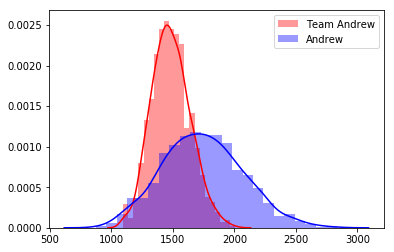

In [92]:
sns.distplot(team_andrew_means,color='red',label="Team Andrew")
sns.distplot(andrew_means,color='blue',label='Andrew')
plt.legend();

It looks like Andrew's mean order totals are more spread out than his team's.  That indicates that he may have some high outliers in his sales.  I'm going to go back to just looking at his data (rather than the sample means).

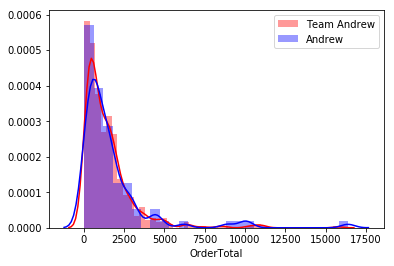

In [93]:
sns.distplot(team_andrew['OrderTotal'],color='red',label="Team Andrew")
sns.distplot(andrew['OrderTotal'],color='blue',label='Andrew')
plt.legend();

Oh yeah, outliers for sure.  I'm going to use the 1.5IQR rule to get rid of the outliers in the data.

In [94]:
team_andrew_stats=team_andrew['OrderTotal'].describe()
andrew_stats=andrew['OrderTotal'].describe()
team_andrew['OrderTotal'].mean(), andrew['OrderTotal'].mean()  #means including outliers for Team Andrew and for Andrew

(1479.7521000000008, 1734.7682812500004)

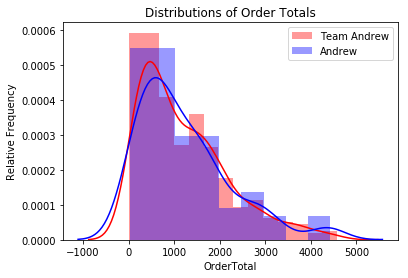

In [95]:
IQR_TA=team_andrew_stats['75%']
upper_limit_TA=1.5*IQR_TA+team_andrew_stats['75%']
team_andrew_no_outliers=team_andrew[team_andrew['OrderTotal']<upper_limit_TA]['OrderTotal']

IQR_A=andrew_stats['75%']
upper_limit_A=1.5*IQR_A+andrew_stats['75%']
andrew_no_outliers=andrew[andrew['OrderTotal']<upper_limit_A]['OrderTotal']

sns.distplot(team_andrew_no_outliers,color="red",label='Team Andrew')
sns.distplot(andrew_no_outliers,color='blue',label='Andrew')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Order Totals')
plt.legend();

In [96]:
t,p=stats.ttest_ind(andrew_no_outliers, team_andrew_no_outliers,equal_var=False)
p

0.8949188277466973

Looking at the groups with all of the outliers removed, Andrew and his team perform much more similarly.  That would indicate that he may have had a couple of abnormally large orders while his team didn't.  However, if Andrew is generating some abnormally large orders, that may indicate he's more talented and/or lucky.

But, let's go back to the sample mean distributions (with no outliers) just to see what that looks like now.

In [102]:
team_andrew_no_outliers_means=sample_means(team_andrew_no_outliers,100,1000)
andrew_no_outliers_means=sample_means(andrew_no_outliers,30,1000)

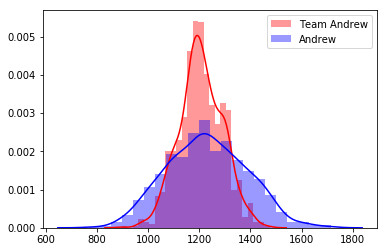

In [105]:
sns.distplot(team_andrew_no_outliers_means,color='red',label="Team Andrew")
sns.distplot(andrew_no_outliers_means,color='blue',label='Andrew')
plt.legend();

There still appears to be a difference in the means.  One more t-test to confirm.

In [106]:
t,p=stats.ttest_ind(andrew_no_outliers_means, team_andrew_no_outliers_means,equal_var=False)
p

5.9163516691411386e-05

The p-value is higher but still far below alpha.  It's pretty safe to say that Andrew performed better than his team.

I'm curious about Team Andrew vs Team Steven without the outliers so I'm going to go through the same process as above to see what happens.

In [107]:
team_andrew_stats=team_andrew['OrderTotal'].describe()
team_steven_stats=team_steven['OrderTotal'].describe()

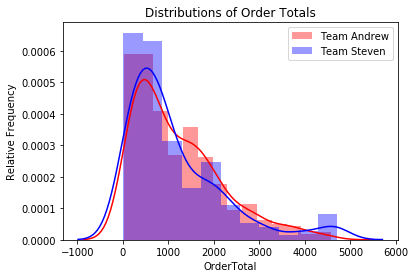

In [108]:
IQR_TA=team_andrew_stats['75%']
upper_limit_TA=1.5*IQR_TA+team_andrew_stats['75%']
team_andrew_no_outliers=team_andrew[team_andrew['OrderTotal']<upper_limit_TA]['OrderTotal']

IQR_TS=team_steven_stats['75%']
upper_limit_TS=1.5*IQR_TS+team_steven_stats['75%']
team_steven_no_outliers=team_steven[team_steven['OrderTotal']<upper_limit_TS]['OrderTotal']

sns.distplot(team_andrew_no_outliers,color="red",label='Team Andrew')
sns.distplot(team_steven_no_outliers,color='blue',label='Team Steven')
plt.ylabel('Relative Frequency')
plt.title('Distributions of Order Totals')
plt.legend();

In [109]:
team_steven_no_outliers_means=sample_means(team_steven_no_outliers,100,1000)
steven_no_outliers_means=sample_means(team_steven_no_outliers,30,1000)

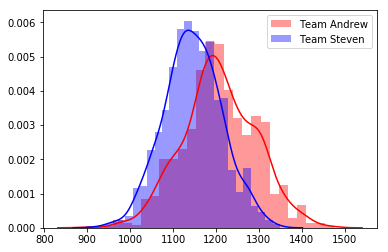

In [110]:
sns.distplot(team_andrew_no_outliers_means,color='red',label="Team Andrew")
sns.distplot(team_steven_no_outliers_means,color='blue',label='Team Steven')
plt.legend();

In [111]:
t,p=stats.ttest_ind(team_steven_no_outliers_means, team_andrew_no_outliers_means,equal_var=False)
p

2.0828606799169383e-65

Without outliers, we can still reject the null hypothesis and, as we can see above, the two plots have a different mean.  Team Andrew and Team Steven seem to be doing similar work but Team Andrew is winning by a nose.

In [112]:
group1=team_andrew_no_outliers_means
group2=team_steven_no_outliers_means
v=np.concatenate([group1,group2])
labels=['TeamAndrew']*len(group1)+['TeamSteven']*len(group2)
print(pairwise_tukeyhsd(v,labels,0.05))

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1     group2   meandiff  lower    upper   reject
-------------------------------------------------------
TeamAndrew TeamSteven -61.0105 -67.7481 -54.2729  True 
-------------------------------------------------------


### Conclusions

Team Steven and Team Andrew do perform differently (where "differently" means about `$60` per order).  Andrew may outperform his team, depending on the circumstances of his orders with higher totals.

## Recommendations

**From Hypothesis Test 1**: Offer a 15 or 25% discount to increase sales.  15% is slightly better.  Further investigation can reveal the intervals and durations of discounts that are most effective.

**From Hypothesis Test 2**:  The season doesn't affect the amount of sales.  Further investigation is needed to determine if discounts are independent from the season. (It may be the case that discounts are offered during the slow seasons, boosting sales and making it look like the sales are the same year-round.)  

**From Hypothesis Test 3**: Produce processes faster than beverages.  Further investigation is needed to determine what mix of categories typically show up in orders.  It may be possible to increase processing time by splitting up perishable/non-perishable items (or some other division of categories).  

**From Hypothesis Test 4**: Both managers' teams are doing similarly well at generating revenue.  Andrew may be outperforming his team and his team is slightly outperforming Steven's team.  Further investigation could reveal the causes behind that which may then be leveraged by other employees to increase the overall revenue of the company. It may be worthwhile to have Andrew train employees. (Or, to have Andrew's trainer train employees).  